In [2]:
import csv
import numpy as np

In [3]:
file = open('files/Trevor_Composites_ES100_1_1.csv')
type(file)

_io.TextIOWrapper

In [4]:
csvreader = csv.reader(file)

In [5]:
header = []
header = next(csvreader)
header

['Specimen text inputs : Specimen text input  1', '', '']

In [6]:
id_dict = {'Basalt 0deg': [1, 2, 3, 4], 'Hemp 45deg': [5, 6, 7, 8], 'Flax 45deg': [9, 10, 11, 12], 'Basalt Hemp 0deg': [13, 14, 15, 16], 'Hemp 0deg': [17, 18, 19, 20], 'Flax 0deg': [21, 22, 23, 24], 'Basalt Flax 0deg': [25, 26, 27, 28]}

In [7]:
import pandas as pd
import numpy as np
import os
import re  # Import regular expressions for finding the id in the file name

id_dict = {'Basalt 0deg': [1, 2, 3, 4], 'Hemp 45deg': [5, 6, 7, 8], 'Flax 45deg': [9, 10, 11, 12], 'Basalt Hemp 0deg': [13, 14, 15, 16], 'Hemp 0deg': [17, 18, 19, 20], 'Flax 0deg': [21, 22, 23, 24], 'Basalt Flax 0deg': [25, 26, 27, 28]}

def get_name_for_id(id_num):
    for name, ids in id_dict.items():
        if id_num in ids:
            return name
    return None 

def convert_to_numeric(df, column_names):
    for column in column_names:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def average_n_values(df, n):
    avg_df = df.groupby(np.arange(len(df)) // n).mean()
    avg_df['Time'] = avg_df['Time'].round().astype(int)
    return avg_df

folder_path = 'files'
n = 50 
dfs = []

names = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Attempt to automatically detect the start of the data
        with open(file_path, 'r') as file:
            for i, line in enumerate(file):
                if line.strip().split(',')[0] == "Time":
                    header_line = i
                    break

        # Extract the id number from the file name using regular expressions
        match = re.search(r"Trevor_Composites_ES100_(\d+)_1.csv", file_name)
        if match:
            id_num = int(match.group(1))
            name = get_name_for_id(id_num)
            if name:
                file_name_modified = file_name.replace(f"Trevor_Composites_ES100_{id_num}_1", f"{name}_{names.count(name) + 1}")
                names.append(name)
            else:
                file_name_modified = file_name
        else:
            file_name_modified = file_name

        df = pd.read_csv(file_path, skiprows=header_line)

        df = convert_to_numeric(df, ['Time', 'Displacement', 'Force'])

        df_avg = average_n_values(df, n)

        df_avg['File_ID'] = os.path.splitext(file_name_modified)[0]

        df_avg['Material_ID'] = file_name.replace(f"Trevor_Composites_ES100_{id_num}_1.csv", f"{name}")

        dfs.append(df_avg)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('combined_averaged.csv', index=False)

print("Processing complete. The combined CSV is saved as 'combined_averaged.csv'.")


C:\Users\james\AppData\Local\Temp\ipykernel_25200\88502435.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Processing complete. The combined CSV is saved as 'combined_averaged.csv'.


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.read_csv('combined_averaged.csv')
file_ids = combined_df['File_ID'].unique()

for file_id in file_ids:
    df_filtered = combined_df[combined_df['File_ID'] == file_id]
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['Time'], df_filtered['Displacement'], label='Displacement vs. Time', marker='o')
    plt.plot(df_filtered['Time'], df_filtered['Force'], label='Force vs. Time', marker='x')
    plt.title(f'Displacement and Force vs. Time for {file_id}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    
    plt.savefig(f"figs/{file_id}_plot.png")
    plt.close()

print("Plots generated and saved.")


Plots generated and saved.


clean data after downtrend

In [91]:
# Load the combined data
combined_df = pd.read_csv('combined_averaged.csv')

def truncate_at_downtrend(df, value_columns):
    """Truncates the DataFrame at the start of a downtrend for specified columns."""
    for column in value_columns:
        # Find the first instance where the next value is less than the current value
        downtrend_start = np.where(df[column].diff() < 0)[0]
        if downtrend_start.size > 0:
            # If a downtrend is found, truncate the DataFrame up to that point
            return df.iloc[:downtrend_start[0]]
    return df

truncated_dfs = []

# Process each unique File_ID
for file_id in combined_df['File_ID'].unique():
    df_filtered = combined_df[combined_df['File_ID'] == file_id]
    
    # Truncate the DataFrame at the start of a downtrend for 'Displacement' and 'Force'
    df_truncated = truncate_at_downtrend(df_filtered, ['Displacement', 'Force'])
    
    truncated_dfs.append(df_truncated)

# Combine truncated DataFrames
truncated_combined_df = pd.concat(truncated_dfs, ignore_index=True)

# Save the truncated combined DataFrame to a new CSV file
truncated_combined_df.to_csv('truncated_combined_averaged.csv', index=False)

print("Truncated data saved to 'truncated_combined_averaged.csv'.")


Truncated data saved to 'truncated_combined_averaged.csv'.


In [92]:
combined_df = pd.read_csv('truncated_combined_averaged.csv')

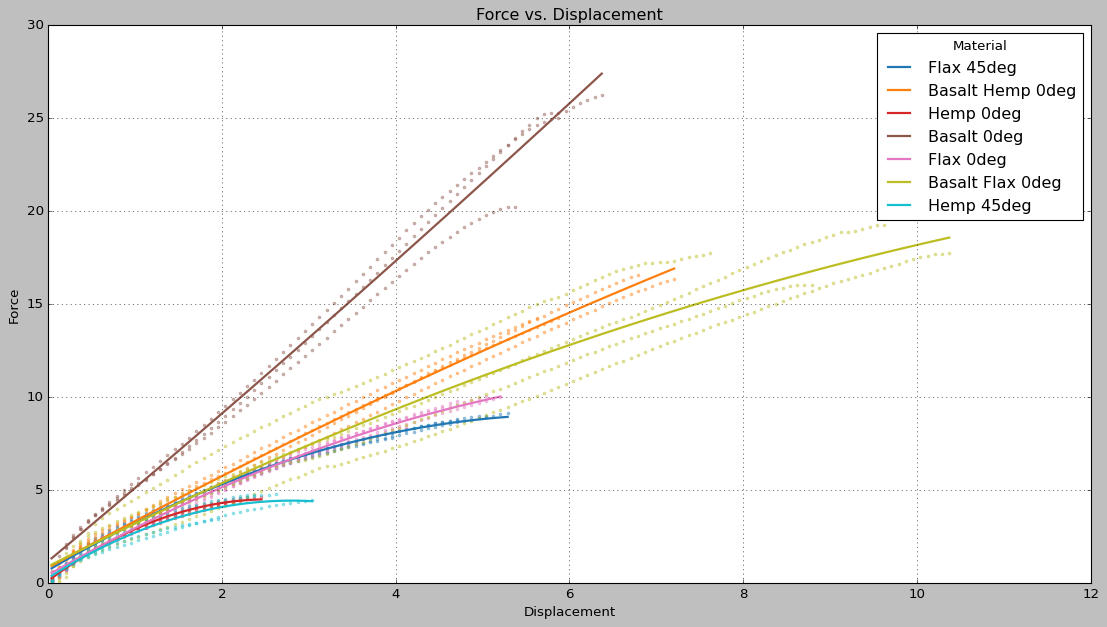

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming combined_df is your DataFrame with at least 'Material_ID', 'Displacement', 'Force' columns.

# Get unique materials and assign colors
unique_materials = combined_df['Material_ID'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_materials)))  # Use tab10 colormap, adjust as needed

# Create a color map: Material -> color
color_map = dict(zip(unique_materials, colors))

plt.figure(figsize=(14, 8))

# Plot all data points with colors corresponding to Material ID
for material_id in unique_materials:
    # Filter rows for the current material ID
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=color_map[material_id], alpha = 0.4, s=5)

    # Fit a polynomial (second degree) to the data points for this material ID
    p = np.polynomial.Polynomial.fit(material_data['Displacement'], material_data['Force'], 2)
    # Generate x values from the min to max displacement for the material
    x = np.linspace(material_data['Displacement'].min(), material_data['Displacement'].max(), 100)
    # Calculate the y values using the polynomial
    y = p(x)
    # Plot the fitting curve
    plt.plot(x, y, color=color_map[material_id], label=f'{material_id}', linewidth=2)

# To avoid duplicate labels in the legend, handle them separately
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates
plt.legend(by_label.values(), by_label.keys(), title="Material")

plt.xlim(0)
plt.ylim(0)

plt.title('Force vs. Displacement')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
plt.xlabel('Displacement')
plt.grid(True)
plt.ylabel('Force')
plt.tight_layout()
plt.savefig('figs/scatter_with_fitting_line_per_material.png')
plt.show()


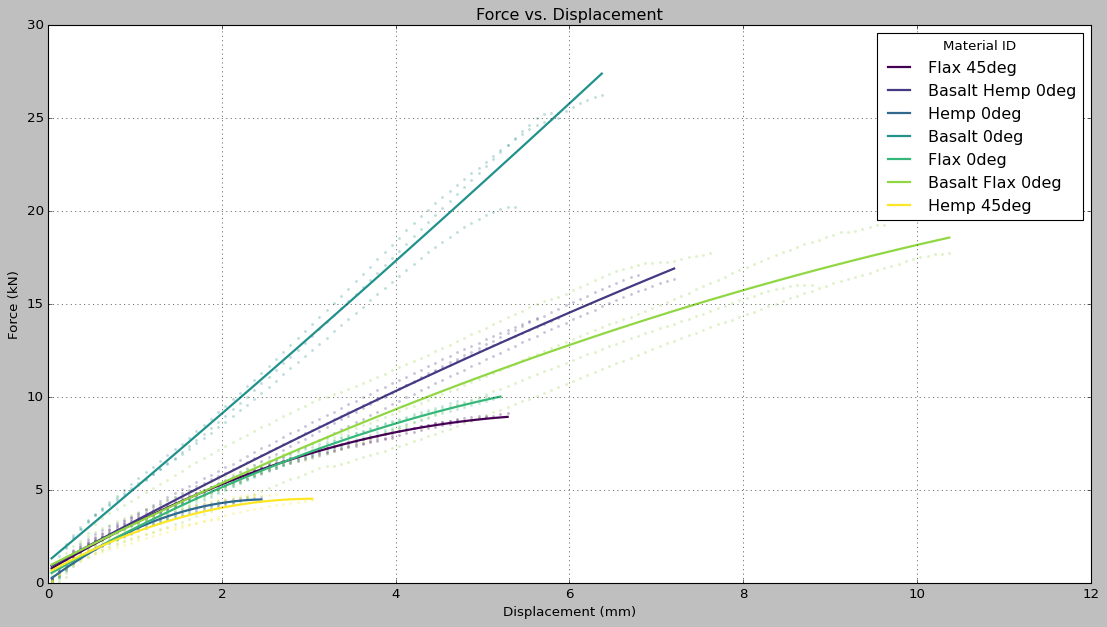

In [104]:
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot all data points with colors corresponding to Material ID
plt.figure(figsize=(14, 8))

for material_id in unique_materials:
    # Filter rows for the current material ID
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=color_map[material_id], alpha=0.2, s=3)

    # Prepare data for polynomial fit with RANSAC
    X = material_data['Displacement'].values.reshape(-1, 1)
    y = material_data['Force'].values

    # Create a RANSAC regressor with a polynomial model
    ransac = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(random_state=42))
    ransac.fit(X, y)

    # Generate x values from the min to max displacement for the material
    x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    # Calculate the y values using the RANSAC polynomial model
    y_ransac = ransac.predict(x)
    # Plot the fitting curve
    plt.plot(x, y_ransac, color=color_map[material_id], linewidth=2, label=f'{material_id}')

# Add legend, titles and labels
# make bottom left of graph 0, 0
plt.xlim(0, None)
plt.ylim(0, None)

plt.legend(title="Material ID")
# Force vs. Displacement with Polynomial Fitting and RANSAC for Each Material
plt.title('Force vs. Displacement')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/polynomial_fit_ransac_per_material.png')
plt.show()


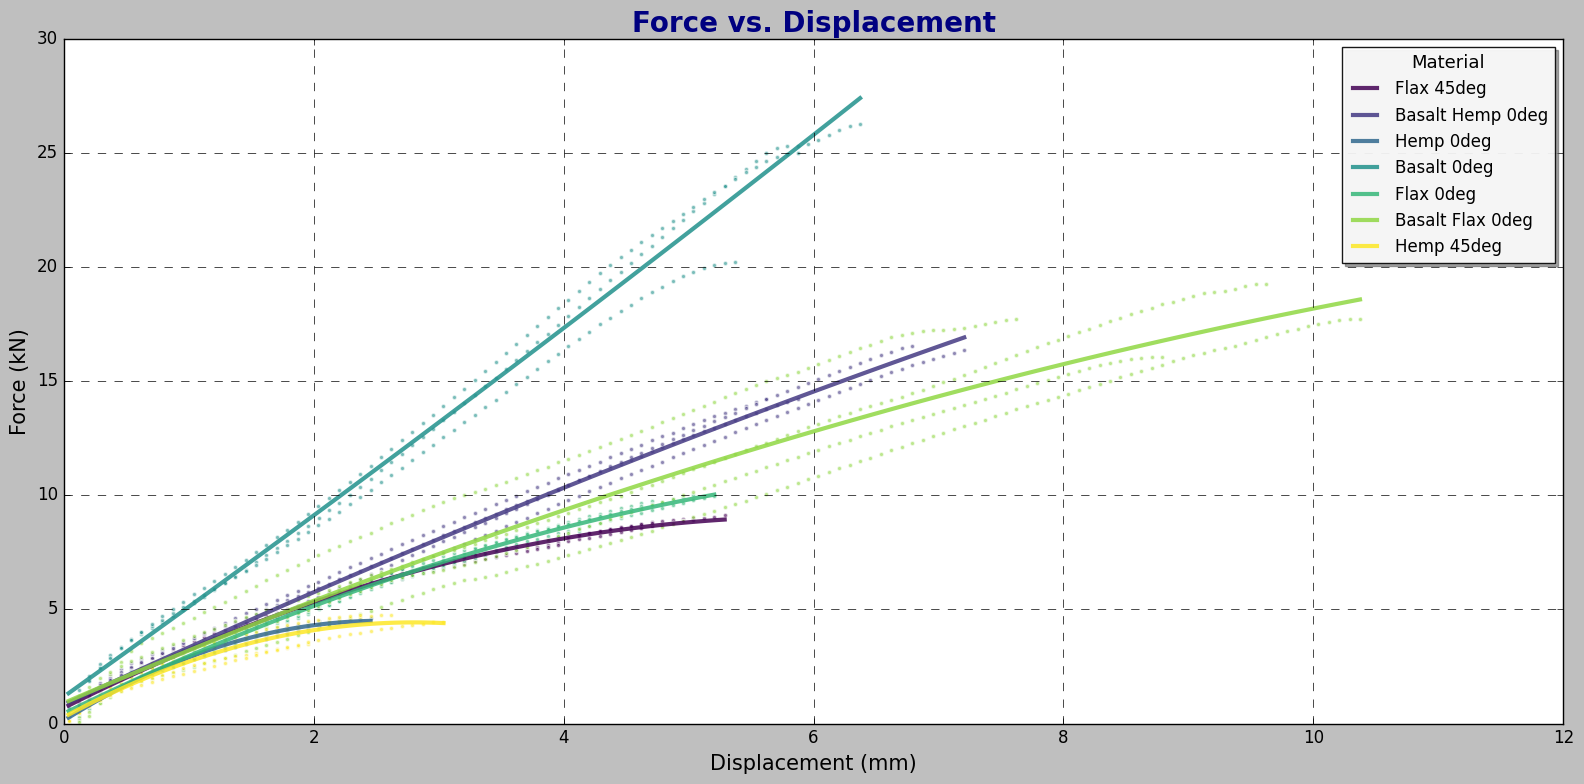

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.style.use('classic')  # Use a more sophisticated style

unique_materials = combined_df['Material_ID'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_materials)))  # Use viridis colormap

color_map = dict(zip(unique_materials, colors))

plt.figure(figsize=(16, 8), dpi=100)  # Increased figure size and resolution
plt.title('Force vs. Displacement', fontsize=20, fontweight='bold', color='navy')
plt.xlabel('Displacement (mm)', fontsize=15)
plt.ylabel('Force (kN)', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Improved grid visibility

# Plot all data points with enhanced styles
for material_id in unique_materials:
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=color_map[material_id], alpha=0.6, s=10, edgecolor='w')

    p = np.polynomial.Polynomial.fit(material_data['Displacement'], material_data['Force'], 2)
    x = np.linspace(material_data['Displacement'].min(), material_data['Displacement'].max(), 100)
    y = p(x)
    plt.plot(x, y, color=color_map[material_id], linewidth=3, label=f'{material_id}', alpha=0.85)  # Increased line visibility

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), title="Material", fontsize=12, title_fontsize='13', loc='best', shadow=True)
legend.get_frame().set_alpha(0.9)  # Semi-transparent legend

plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig('figs/scatter_with_fitting_line_per_material_sexy.png')
plt.show()


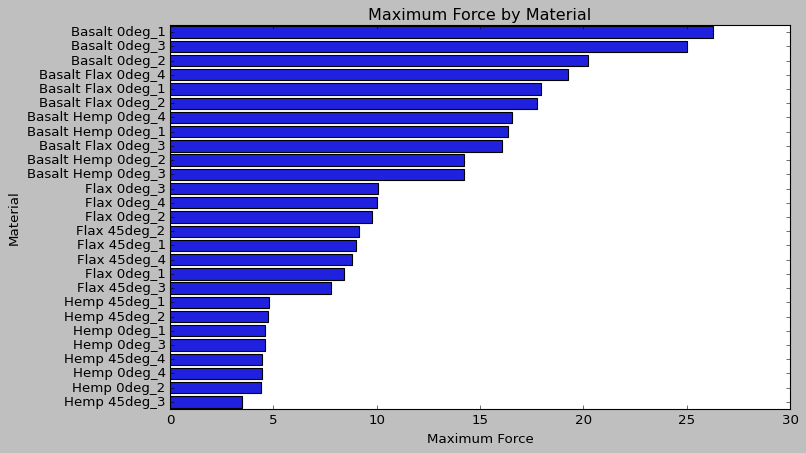

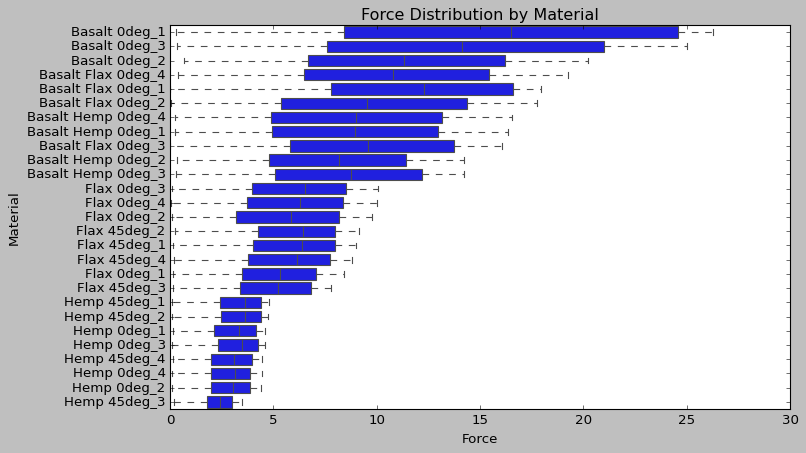

In [98]:
import seaborn as sns

df = pd.read_csv('combined_averaged.csv')

max_force_per_material = df.groupby('File_ID')['Force'].max().reset_index()

max_force_per_material = max_force_per_material.sort_values(by='Force', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Force', y='File_ID', data=max_force_per_material)
plt.title('Maximum Force by Material')
plt.xlabel('Maximum Force')
plt.ylabel('Material')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Force', y='File_ID', data=df, order=max_force_per_material['File_ID'])
plt.title('Force Distribution by Material')
plt.xlabel('Force')
plt.ylabel('Material')
plt.show()


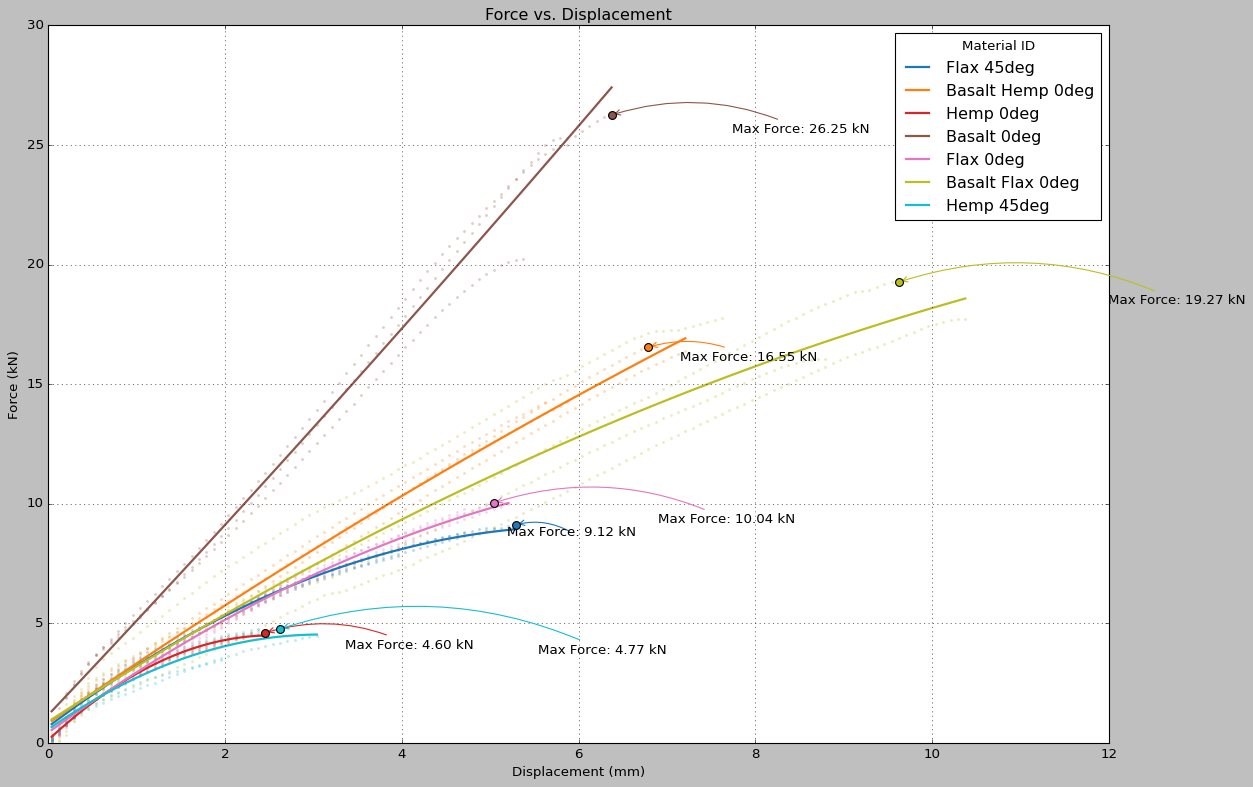

In [139]:
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming combined_df and color_map are already defined

plt.figure(figsize=(16, 10))

annotation_positions = []

for material_id in unique_materials:
    # Filter rows for the current material ID
    material_data = combined_df[combined_df['Material_ID'] == material_id]
    plt.scatter(material_data['Displacement'], material_data['Force'], color=color_map[material_id], alpha=0.2, s=3)

    # Prepare data for polynomial fit with RANSAC
    X = material_data['Displacement'].values.reshape(-1, 1)
    y = material_data['Force'].values

    # Create a RANSAC regressor with a polynomial model
    ransac = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(random_state=42))
    ransac.fit(X, y)

    # Generate x values from the min to max displacement for the material
    x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    # Calculate the y values using the RANSAC polynomial model
    y_ransac = ransac.predict(x)
    # Plot the fitting curve
    plt.plot(x, y_ransac, color=color_map[material_id], linewidth=2, label=f'{material_id}')

    # Correct placement: Calculate and plot the max force point within the loop
    max_force = material_data['Force'].max()
    max_force_disp = material_data.loc[material_data['Force'].idxmax(), 'Displacement']
    plt.scatter(max_force_disp, max_force, color=color_map[material_id], edgecolor='black', 
                s=50, zorder=5)

    # Determine a suitable position for the annotation
    xytext = (50, -10)  # Default annotation offset

    # Check for overlap and adjust position if necessary
    while any(np.linalg.norm(np.array((xytext[0], xytext[1])) - np.array(pos)) < 30 for pos in annotation_positions):
        xytext = (xytext[0] + 20, xytext[1] - 1)  # Adjust position to reduce overlap

    annotation_positions.append(xytext)  # Store the position

    # Annotate with a connection line
    plt.annotate(f'Max Force: {max_force:.2f} kN', 
                 (max_force_disp, max_force),
                 textcoords="offset points", 
                 xytext=xytext, 
                 ha='center', 
                 fontsize=12,
                 arrowprops=dict(arrowstyle="->", color=color_map[material_id], connectionstyle="arc3,rad=0.2"))

# Add legend, titles, and labels
plt.xlim(0, None)
plt.ylim(0, None)
plt.legend(title="Material ID")
plt.title('Force vs. Displacement')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/polynomial_fit_ransac_per_material_corrected.png')
plt.show()
